# Time invariant filtering

Time invariant filtering (with Finite impulse response filter) is equivalent to Conv1D with fixed kernel paramters.

This can be implemented easily on the basis of conv1d defined previously.

Given input tensor (batchsize, length, dim), output tensor will be in size (batchsize, length, dim)

Just treat input tensor (batchsize=B, length, dim=N) as BxN 1-d signals of size (1, length, 1), and conduct FIR filtering over all the BxN signals.


In [1]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# repeat the definition of Conv1dKeepLength
class Conv1dKeepLength(torch_nn.Conv1d):
    """ Wrapper for causal convolution
    Input tensor:  (batchsize, length, dim_in)
    Output tensor: (batchsize, length, dim_out)
    
    Implemented based on:
    https://github.com/pytorch/pytorch/issues/1333
    
    Define:
        see __init__ below
        
    """
    def __init__(self, input_dim, output_dim, dilation_s, kernel_s, 
                 causal = False, stride = 1, groups=1, bias=True, \
                 tanh = True, pad_mode='constant'):
        super(Conv1dKeepLength, self).__init__(
            input_dim, output_dim, kernel_s, stride=1,
            padding = 0, dilation = dilation_s, groups=groups, bias=bias)

        self.pad_mode = pad_mode
        self.causal = causal
        
        # padding size
        # input & output length will be the same
        if self.causal:
            # left pad to make the convolution causal
            self.pad_le = dilation_s * (kernel_s - 1)
            self.pad_ri = 0
        else:
            # pad on both sizes
            self.pad_le = dilation_s * (kernel_s - 1) // 2
            self.pad_ri = dilation_s * (kernel_s - 1) - self.pad_le
    
        # activation functions
        if tanh:
            self.l_ac = torch_nn.Tanh()
        else:
            self.l_ac = torch_nn.Identity()
        
    def forward(self, data):
        # https://github.com/pytorch/pytorch/issues/1333
        # permute to (batchsize=1, dim, length)
        # add one dimension as (batchsize=1, dim, ADDED_DIM, length)
        # pad to ADDED_DIM
        # squeeze and return to (batchsize=1, dim, length+pad_length)
        x = torch_nn_func.pad(data.permute(0, 2, 1).unsqueeze(2), \
                              (self.pad_le, self.pad_ri,0,0), \
                              mode = self.pad_mode).squeeze(2)
        # tanh(conv1())
        # permmute back to (batchsize=1, length, dim)
        output = self.l_ac(super(Conv1dKeepLength, self).forward(x))
        return output.permute(0, 2, 1)
    


In [3]:
# definition of TimeInvFIRFilter

class TimeInvFIRFilter(Conv1dKeepLength):                                    
    """ Wrapper to define a FIR filter
        input tensor  (batchsize, length, feature_dim)
        output tensor (batchsize, length, feature_dim)
        
        Define:
            TimeInvFIRFilter(feature_dim, filter_coef, 
                             causal=True, flag_trainable=False)
        feature_dim: 
        filter_coef: a 1-D torch.tensor of the filter coefficients
        causal: causal filtering y_i = sum_k=0^K a_k x_i-k
                non-causal: y_i = sum_k=0^K a_k x_i+K/2-k
        flag_trainable: whether update filter coefficients (default False)
    """                                                                   
    def __init__(self, feature_dim, filter_coef, causal=True, 
                 flag_trainable=False):
        # define based on Conv1d with stride=1, tanh=False, bias=False
        # groups = feature_dim make sure that each signal is filtered separated 
        super(TimeInvFIRFilter, self).__init__(                              
            feature_dim, feature_dim, 1, filter_coef.shape[0], causal,              
            groups=feature_dim, bias=False, tanh=False)
        
        if filter_coef.ndim == 1:
            # initialize weight and load filter coefficients
            with torch.no_grad():
                tmp_coef = torch.zeros([feature_dim, 1, filter_coef.shape[0]])
                tmp_coef[:, 0, :] = filter_coef
                tmp_coef = torch.flip(tmp_coef, dims=[2])
                self.weight = torch.nn.Parameter(tmp_coef, requires_grad = flag_trainable)
        else:
            print("TimeInvFIRFilter expects filter_coef to be 1-D tensor")
            print("Please implement the code in __init__ if necessary")
            sys.exit(1)
                                                                                  
    def forward(self, data):                                              
        return super(TimeInvFIRFilter, self).forward(data)

## Examples

([<matplotlib.axis.XTick at 0x7ff670878ca0>,
 <a list of 3 Text xticklabel objects>)

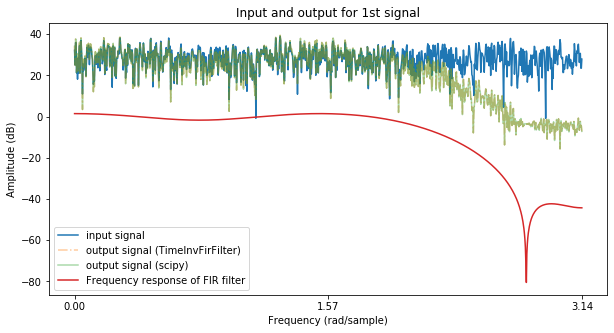

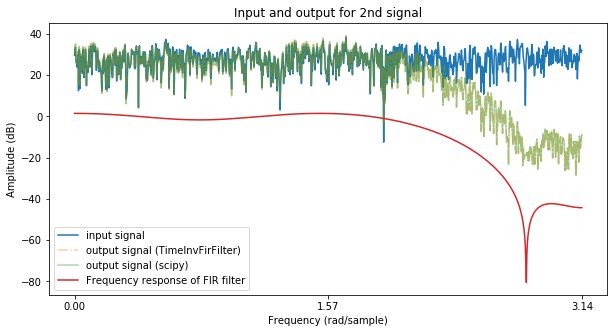

In [16]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

# A few filters we can try
lp_v = [0.08538414199291068, 0.04920229475534168, -0.1470178606967731, 0.24737764593887432, 0.7103067853166558, 0.24737764593887432, -0.1470178606967731, 0.04920229475534168, 0.08538414199291068]
lp_u = [0.00936455546502, 0.0416254862901, 0.0878313219556, 0.146086321198, 0.192602581136, 0.211221591449, 0.192602581136, 0.146086321198, 0.0878313219556, 0.0416254862901, 0.00936455546502]
hp_v = [-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122, -0.19260258113649556,  0.21122159144894015, -0.19260258113649556, 0.1460863211980122, -0.08783132195564508, 0.04162548629009957, -0.00936455546502148]
hp_u = [0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929]

# let's try a loss-pass filter
coef = lp_v

# configurations
signal_dim = 2
signal_length = 1000
batch_size = 2

# Do filtering using TimeInvFIRFilter
filter_layer = TimeInvFIRFilter(signal_dim, torch.tensor(coef))
with torch.no_grad():
    # input signal
    signal_input = torch.randn(batch_size, signal_length, signal_dim)
    
    # get output signal
    signal_output = filter_layer(signal_input)
    
# Do filtering using scipy, doing it separately for the two signals 
scipy_out_1 = scipy.signal.lfilter(coef, [1], signal_input.detach().numpy()[0, :, 0])
scipy_out_2 = scipy.signal.lfilter(coef, [1], signal_input.detach().numpy()[0, :, 1])

# plot results
# fft points for figure plotting (nfft should be > signal_length)
nfft = 2048

# plot for the signal in (0, :, 0)
plt.figure()
h = scipy.fft.fft(signal_input[0, :, 0].detach().numpy(), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps))

h = scipy.fft.fft(signal_output[0, :, 0].detach().numpy(), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), '-.', alpha=0.4)

h = scipy.fft.fft(scipy_out_1, n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), alpha=0.4)

w, h = scipy.signal.freqz(coef, [1], worN=nfft, whole=True)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps))
plt.legend(['input signal', 'output signal (TimeInvFirFilter)', 'output signal (scipy)', 'Frequency response of FIR filter'])
plt.title('Input and output for 1st signal')
plt.xlabel('Frequency (rad/sample)')
plt.ylabel('Amplitude (dB)')
plt.xticks([0, nfft // 4, nfft // 2], ['%1.2f' % (x * 2 * np.pi) for x in [0, 0.25, 0.5]])
    
# plot for the signal in (0, :, 1)
plt.figure()
h = scipy.fft.fft(signal_input[0, :, 1].detach().numpy(), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps))

h = scipy.fft.fft(signal_output[0, :, 1].detach().numpy(), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), '-.',  alpha=0.4)

h = scipy.fft.fft(scipy_out_2, n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), alpha=0.4)

w, h = scipy.signal.freqz(coef, [1], worN=nfft, whole=True)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps))
plt.legend(['input signal', 'output signal (TimeInvFirFilter)', 'output signal (scipy)', 'Frequency response of FIR filter'])
plt.title('Input and output for 2nd signal')
plt.xlabel('Frequency (rad/sample)')
plt.ylabel('Amplitude (dB)')
plt.xticks([0, nfft // 4, nfft // 2], ['%1.2f' % (x * 2 * np.pi) for x in [0, 0.25, 0.5]])


You can try plot with other filter coefficients and other signals in the input tensor

# Signal smoothing using Moving average

It is also straightforward to define moving-average-based signal smoothing function based on Conv1dKeepLength

While it is possible to define it using TimeInvFilter, I directly define in through Conv1dKeepLength

In [17]:
class MovingAverage(Conv1dKeepLength):                                    
    """ Wrapper to define a moving average smoothing layer based on Conv1dKeepLength
    input tensor  (batchsize, length, feature_dim)
    output tensor (batchsize, length, feature_dim)
    Moving averaging is conducted separately for each feature_dimension and each sequence 
    
    Define: 
        MovingAverage(feature_dim, window_len, causal=False)
        
        feature_dim: 
        window_len: the length of the moving average window
        causal: when False, the window is centered on the current point
                when True, it is y_i = 1/K * sum_k=0^K x_i-k 
    """                                                                   
    def __init__(self, feature_dim, window_len, causal=False):            
        super(MovingAverage, self).__init__(                              
            feature_dim, feature_dim, 1, window_len, causal,              
            groups=feature_dim, bias=False, tanh=False)
        # same
        torch_nn.init.constant_(self.weight, 1/window_len)                
        for p in self.parameters():                                       
            p.requires_grad = False                                       
                                                                          
    def forward(self, data):                                              
        return super(MovingAverage, self).forward(data)

Text(0.5, 1.0, 'Input and output signals after moving averge')

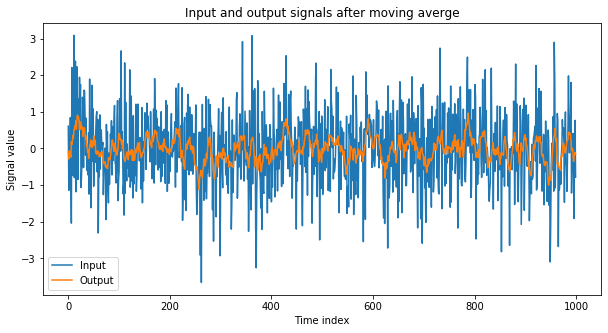

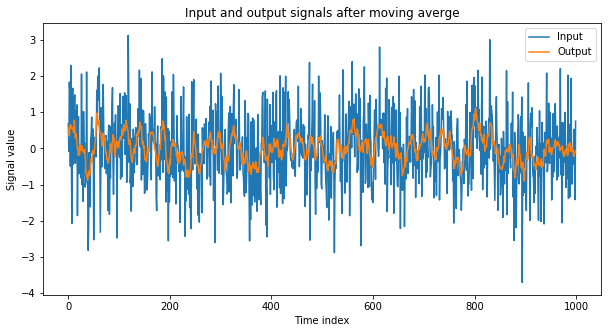

In [19]:
    
# configurations
signal_dim = 2
signal_length = 1000
batch_size = 2
window_size_1 = 10

# Do filtering using TimeInvFIRFilter
ave_layer = MovingAverage(signal_dim, window_size_1, causal = False)

with torch.no_grad():
    # input signal (random noise)
    signal_input = torch.randn(batch_size, signal_length, signal_dim)
    
    # get output signal
    signal_output = ave_layer(signal_input)

plt.figure()
plt.plot(signal_input[0, :, 0])
plt.plot(signal_output[0, :, 0])
plt.xlabel('Time index')
plt.ylabel('Signal value')
plt.legend(['Input', 'Output'])
plt.title('Input and output signals after moving averge')


plt.figure()
plt.plot(signal_input[0, :, 1])
plt.plot(signal_output[0, :, 1])
plt.xlabel('Time index')
plt.ylabel('Signal value')
plt.legend(['Input', 'Output'])
plt.title('Input and output signals after moving averge')
